In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By

import time
import pandas as pd
import os

In [2]:
driver=webdriver.Chrome("chromedriver.exe")

driver.implicitly_wait(3)

C:\Users\kyoun\AppData\Local\Temp\ipykernel_19196\594694961.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver=webdriver.Chrome("chromedriver.exe")


1. 상품들 페이지 열기

In [3]:
site = "https://www.coupang.com/np/categories/420186"
driver.get(site)
time.sleep(1)

2. 상품 페이지의 리스트 부분을 FruitList에 넣기

요소들의 id, class 등을 확인하는 방법 -> 원하는 요소를 우클릭해서 inspect/검사를 누르면 해당 부분을 확인 가능

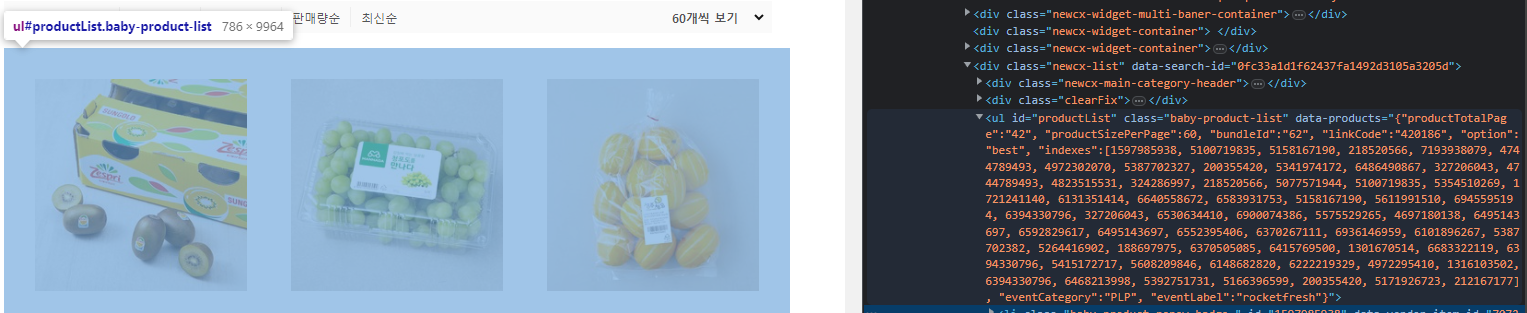

과일들이 들어있는 부분의 ID가 'productList'

In [4]:
FruitList = driver.find_element(By.ID, 'productList')

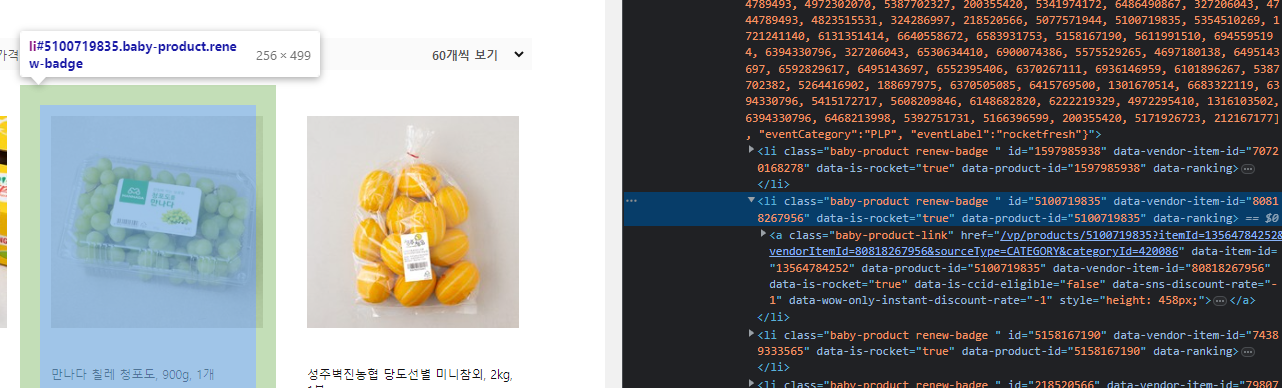

개별 상품은 위에서 찾은 부분의 하위에 존재, 개별 상품 항목 내부에 class가 'baby-product-link'로 된 부분에 링크가 href='link'로 저장되어 있음

In [5]:
FruitList.find_element(By.XPATH, './li['+'1'+']').find_element(By.CLASS_NAME,'baby-product-link').get_attribute("href")

'https://www.coupang.com/vp/products/1597985938?itemId=2730021737&vendorItemId=70720168278&sourceType=CATEGORY&categoryId=420086'

./로 전체 XPATH를 입력하지 않고 FruitList의 XPATH에 이어서 붙인 XPATH를 사용할 수 있다

XPATH of FruitList: /html/body/div[3]/section/form/div/div/div[1]/div[4]/ul

XPATH of each fruit: /html/body/div[3]/section/form/div/div/div[1]/div[4]/ul/li[?] -> ?는 값이 1부터 시작해서 순서대로 증가한다

XPATH를 찾는 방법: 원하는 요소를 개발자 도구에서 찾아서 우클릭->Copy->Copy full XPath

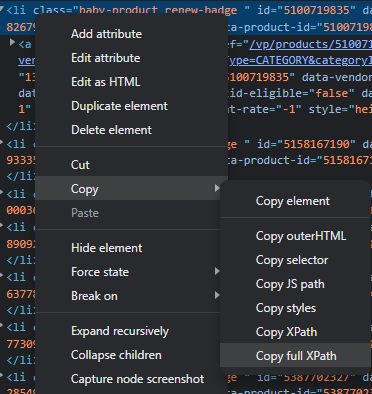

한 페이지 내의 주소들을 다 긁어오는 코드

In [6]:
i = 1
links = []
while True:
    try:
        temp = FruitList.find_element(By.XPATH, './li['+str(i)+']')
        link = temp.find_element(By.CLASS_NAME,'baby-product-link').get_attribute("href")
        links.append(link)
        i+=1
    except:
        break

In [7]:
# 총 저장된 링크 수
len(links)

60

In [8]:
# 마지막에 저장된 링크를 확인
links[-1]

'https://www.coupang.com/vp/products/212167177?itemId=639172683&vendorItemId=4667676914&sourceType=CATEGORY&categoryId=420086'

2. 저장한 상품 페이지 링크들을 하나씩 들어가면서 링크 가져오기

마지막에 저장된 링크를 예시로 진행

In [9]:
driver.get(links[-1])

리뷰 버튼 클릭

name이 "review"이므로 이를 이용해서 리뷰 탭으로 넘어가는 버튼의 위치를 찾는다

In [13]:
driver.find_element(By.NAME, 'review').click()
time.sleep(3)

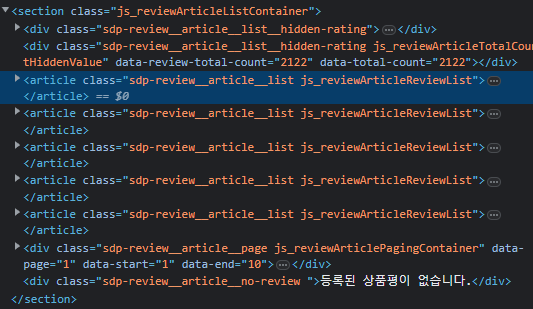

class가 "js_reviewArticleListContainer"인 것에 리뷰들이 들어있고 class가 "sdp-review__article__page js_reviewArticlePagingContainer"에 리뷰 탭의 상태가 data-page, data-start, data-end로 들어 있고 하위에 옮겨가는 버튼이 들어있다

In [14]:
review = driver.find_element(By.CLASS_NAME, "js_reviewArticleListContainer")

In [20]:
i=0 # i는 현재까지 저장된 리뷰의 수를 의미
j=0 # j는 보여지는 리뷰들의 순서와 관련
data = []
while True:
    i += 1
    j += 1
    try:    # 리뷰 평점 저장
        data.append(review.find_element(By.XPATH, "./article["+str(j)+"]/div[1]/div[3]/div[1]/div").get_attribute("data-rating"))
    except: # 보여지는 리뷰들을 다 불러와서 그 이후의 리뷰가 없어 에러가 나면 실행 - 다음 리뷰들을 띄운다
        j = 0
        # 리뷰 탭의 정보와 버튼들이 있는 부분을 XPATH로 찾음
        page = driver.find_element(By.XPATH, "/html/body/div[2]/section/div[2]/div[7]/ul[2]/li[3]/div/div[6]/section[4]/div[3]")
        p = int(page.get_attribute("data-page"))%10+2
        page.find_element(By.XPATH, "./button["+str(p)+"]").click()
        time.sleep(3)
    if i >= 10:
        break

이제 저장된 사이트 링크 모두를 대상으로 실행해보기

In [22]:
for i in links:
    driver.get(i)
    time.sleep(2)   # 페이지 이동 시에 완전히 로딩되지 않았음에도 되는 경우 방지용 3초 대기
    
    title = driver.find_element(By.CLASS_NAME, "prod-buy-header__title").text # 상품명 저장
    
    driver.find_element(By.NAME, 'review').click()
    time.sleep(2)
    review = driver.find_element(By.CLASS_NAME, "js_reviewArticleListContainer")

    i=0 # i는 현재까지 저장된 리뷰의 수를 의미
    j=0 # j는 보여지는 리뷰들의 순서와 관련
    score = []

    while True:
        i += 1
        j += 1
        try:    # 리뷰 평점 저장
            score.append(review.find_element(By.XPATH, "./article["+str(j)+"]/div[1]/div[3]/div[1]/div").get_attribute("data-rating"))
        except: # 보여지는 리뷰들을 다 불러와서 그 이후의 리뷰가 없어 에러가 나면 실행 - 다음 리뷰들을 띄운다
            j = 0
            try:
                page = driver.find_element(By.XPATH, "/html/body/div[2]/section/div[2]/div[7]/ul[2]/li[3]/div/div[6]/section[4]/div[3]")
                p = int(page.get_attribute("data-page"))%10+2
                page.find_element(By.XPATH, "./button["+str(p)+"]").click()
                time.sleep(1)
            except:
                break        
        if i >= 10:
            break
        
    dic = {"review-score": score}
    df = pd.DataFrame(dic)
    df.to_csv(os.getcwd()+"\\"+title+'.csv', index=False, encoding='utf-8-sig')
    print(title+" 저장 완료")
    

제스프리 썬골드키위 저장 완료
만나다 칠레 청포도 저장 완료
성주벽진농협 당도선별 미니참외 저장 완료
스위티오 Dole 바나나 저장 완료
곰곰 국내산 블루베리(대) 저장 완료
스윗토 스테비아 대추방울토마토 저장 완료
프레쉬팜 골드 파인애플 스틱 저장 완료
만나 프레시 믹스 파인 포도 방울 150g x 3p + 사과 포도 방울 150g x 3p 저장 완료
퓨어스펙 고당도 오렌지 저장 완료
곰곰 당도선별 수박 (함안) 저장 완료
델몬트 골드파인 저장 완료
충남세도 GAP 인증 대추방울토마토 저장 완료
스테비아 스윗토 대추방울토마토 저장 완료
썬키스트 고당도 오렌지 중대과 저장 완료
곰곰 세척 사과 저장 완료
Dole 스위티오 바나나 저장 완료
곰곰 당도선별 성주참외 저장 완료
만나다 칠레산 씨없는 청포도 저장 완료
곰곰 농협 영주 당도선별 세척사과 저장 완료
제스프리 왕점보 썬골드키위 저장 완료
저탄소 인증 하이프루츠 당도선별 세척사과 10~12입 저장 완료
스위프리 스테비아 토마토 저장 완료
웰프레쉬 칠레산 체리 (냉동) 저장 완료
성주벽진농협 당도선별 미니참외 저장 완료
프레샤인 GAP 인증 충주 못난이사과 저장 완료
달콤한농부 스테비아 스타마토 저장 완료
만나다 미국 고당도 오렌지 저장 완료
충남세도 GAP 인증 대추방울토마토 저장 완료
딜라잇가든 냉동 유기농 블루베리 500g x 3 저장 완료
곰곰 안동 시나노 골드사과 저장 완료
돌 페루산 아보카도 저장 완료
GAP 완숙토마토 저장 완료
제스프리 썬골드 키위 저장 완료
델몬트 허니글로우 파인스틱 6입 저장 완료
제스프리 썬골드 키위 저장 완료
파인토 스테비아 방울토마토 저장 완료
새벽경매 시원달콤한 수박 저장 완료
올프레쉬 GAP 인증 화이트 딸기 저장 완료
곰곰 달콤한 스테비아 대추방울토마토 저장 완료
만나 골드 프레쉬컷 파인애플 저장 완료
곰곰 GAP 당도선별 제주 카라향 저장 완료
성주월항농협 당도선별 참외 저장 완료
새벽경매 아삭달콤 꼬마참외 저장 완료
딜리조이 시나노 골드 못난이 사과 저장 완료


In [23]:
driver.quit()

참고하면 좋은 사이트

https://www.selenium.dev/selenium/docs/api/java/org/openqa/selenium/WebElement.html